# Background

Links:
- [BayesSearchCV](https://scikit-optimize.github.io/stable/modules/generated/skopt.BayesSearchCV.html)
- [BayesSearchCV Docs Example](https://scikit-optimize.github.io/stable/auto_examples/sklearn-gridsearchcv-replacement.html)

In [1]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from lightgbm import LGBMClassifier
from scipy.stats import uniform, randint
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.utils.fixes import loguniform
from skopt import BayesSearchCV
from skopt.plots import plot_objective, plot_histogram
from skopt.space import Real, Integer
from time import time

plt.style.use("../style.mplstyle")
%matplotlib inline

In [2]:
data = pd.read_csv("../data/cardio.csv", sep=";", index_col=0)
n_samples = 20000
X, y = data.iloc[:n_samples, :-1].values, data.iloc[:n_samples, -1].values
print(f"Number of records         : {X.shape[0]}")
print(f"Number of features        : {X.shape[1]}")
print(f"Count of positive outcomes: {sum(y)} ({sum(y)/len(y)*100:.1f}%)")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)
data.sample(10)

Number of records         : 20000
Number of features        : 11
Count of positive outcomes: 9861 (49.3%)


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
76277,19042,2,165,55.0,120,80,1,1,0,0,1,0
82044,23437,1,148,62.0,150,80,3,1,0,0,1,1
54156,17401,1,168,92.0,110,70,1,1,0,0,0,0
31348,20206,1,159,65.0,110,80,1,1,0,0,1,0
6372,16081,2,173,75.0,110,70,1,1,0,0,1,0
32776,23165,1,153,48.0,140,90,1,1,0,0,1,1
5009,21175,2,178,65.0,120,80,1,1,1,0,1,0
51901,23422,2,165,68.0,120,80,1,1,0,0,1,0
24275,15942,2,170,75.0,120,80,1,1,0,0,0,0


In [3]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=42)
model = LGBMClassifier(random_state=42)

## BayesSearchCV

In [4]:
lgb_params = {
    "num_leaves": Integer(7, 127),
    "max_depth": Integer(0, 250),
    "learning_rate": (1e-3, 1e+2, 'log-uniform'),
    "min_child_samples": Integer(5, 100),
    "reg_alpha": (0, 1, 'log-uniform'),
    "reg_lambda": (0, 1, 'log-uniform'),
}

In [5]:
start = time()

opt = BayesSearchCV(
    model, lgb_params, n_iter=32, cv=cv, n_jobs=1, random_state=42, scoring="roc_auc"
)
print(f"Number of iterations: {opt.total_iterations}")  # n_iter * len(rf_params)

best_score, iteration = 0, 0
# callback handler
def on_step(optim_result):
    global best_score
    global iteration
    iteration += 1
    score = opt.best_score_
    if score > best_score:
        best_score = score
        print(f"\nBest score (iteration): {best_score:.4f} ({iteration})")
    elif iteration % 5 == 0:
        print(
            f"Iteration {iteration}, runtime {(time() - start) / 60:.1f} minutes...",
            end="\r",
        )

opt.fit(X_train, y_train, callback=on_step)
end = time()
print(f"\nRun time     : {(end - start) / 60:.1f} minutes")
print(f"Best score     : {opt.best_score_:.4f}")
print(f"Test score     : {opt.score(X_test, y_test):.4f}")
print("Best parameters:")
for item in opt.best_params_.items():
    print(f"\t{item}")

Number of iterations: 192

Best score (iteration): 0.7888 (1)
Iteration 5, runtime 0.0 minutes...
Best score (iteration): 0.7923 (10)

Best score (iteration): 0.7993 (13)
Iteration 25, runtime 0.7 minutes...
Best score (iteration): 0.7994 (30)

Run time     : 0.9 minutes
Best score     : 0.7994
Test score     : 0.7930
Best parameters:
	('learning_rate', 0.04956014943070258)
	('max_depth', 250)
	('min_child_samples', 5)
	('num_leaves', 7)
	('reg_alpha', 0)
	('reg_lambda', 0)


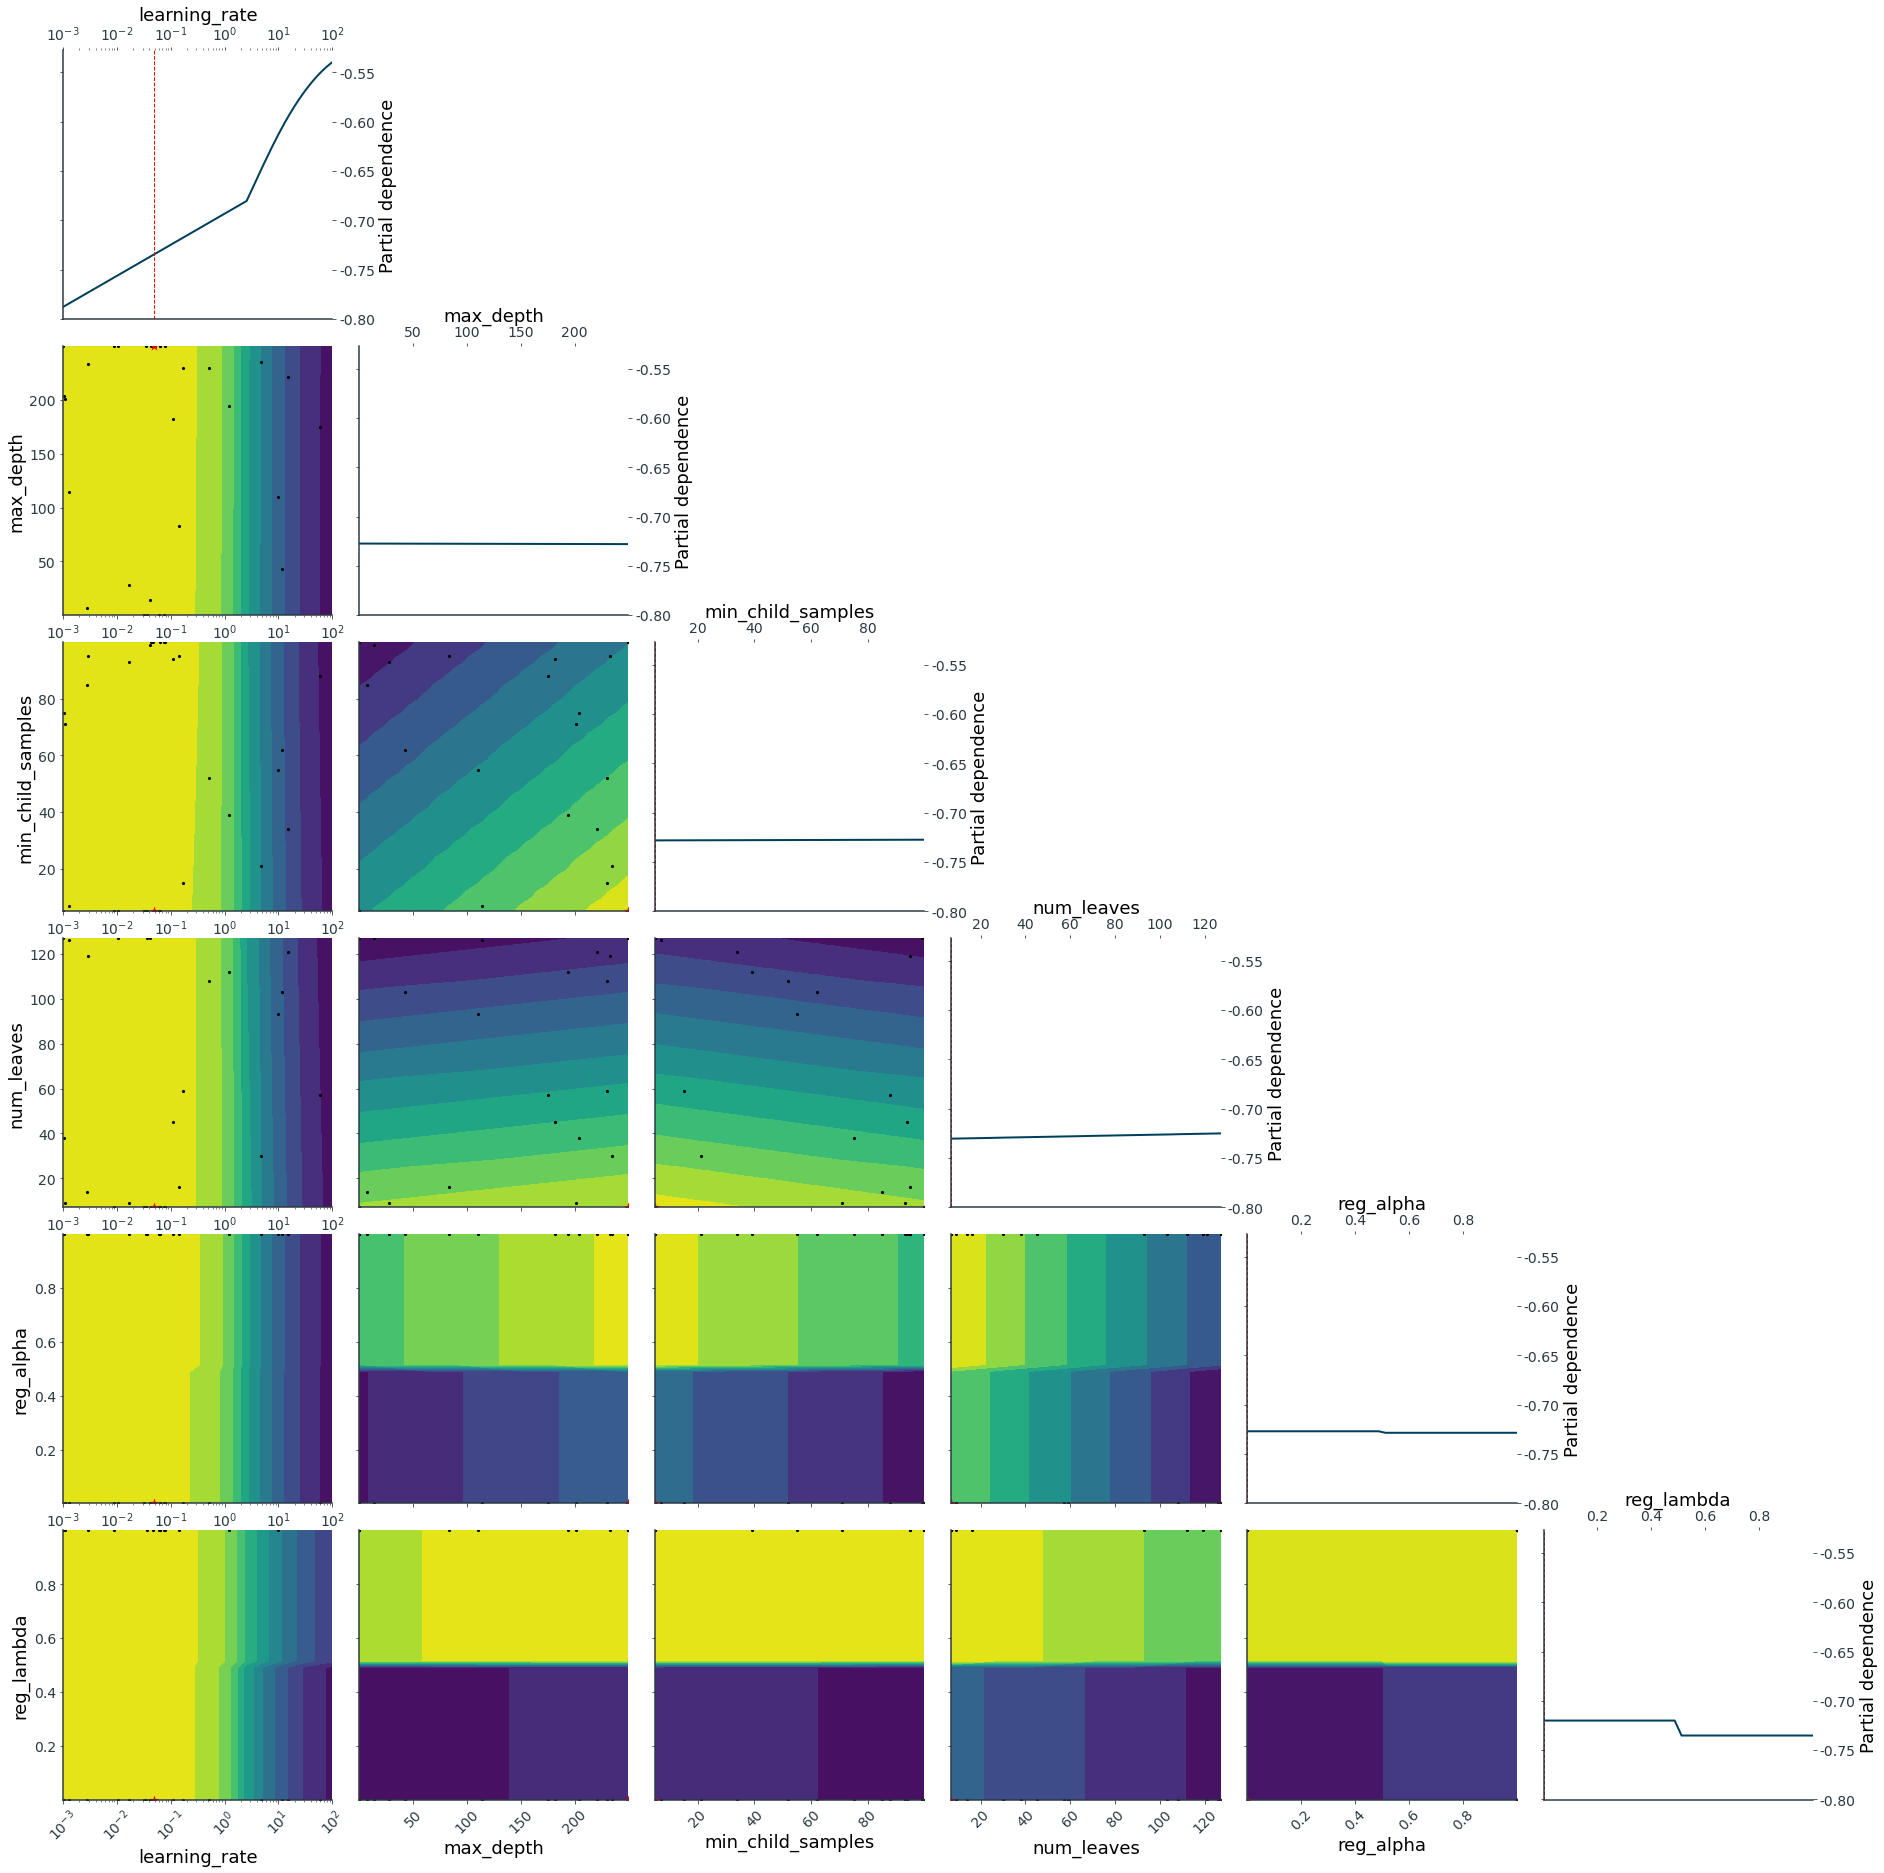

In [6]:
_ = plot_objective(
    opt.optimizer_results_[0],
    dimensions=[
        "learning_rate",
        "max_depth",
        "min_child_samples",
        "num_leaves",
        "reg_alpha",
        "reg_lambda",
    ],
    n_minimum_search=int(1e8),
    size=4.5,
)

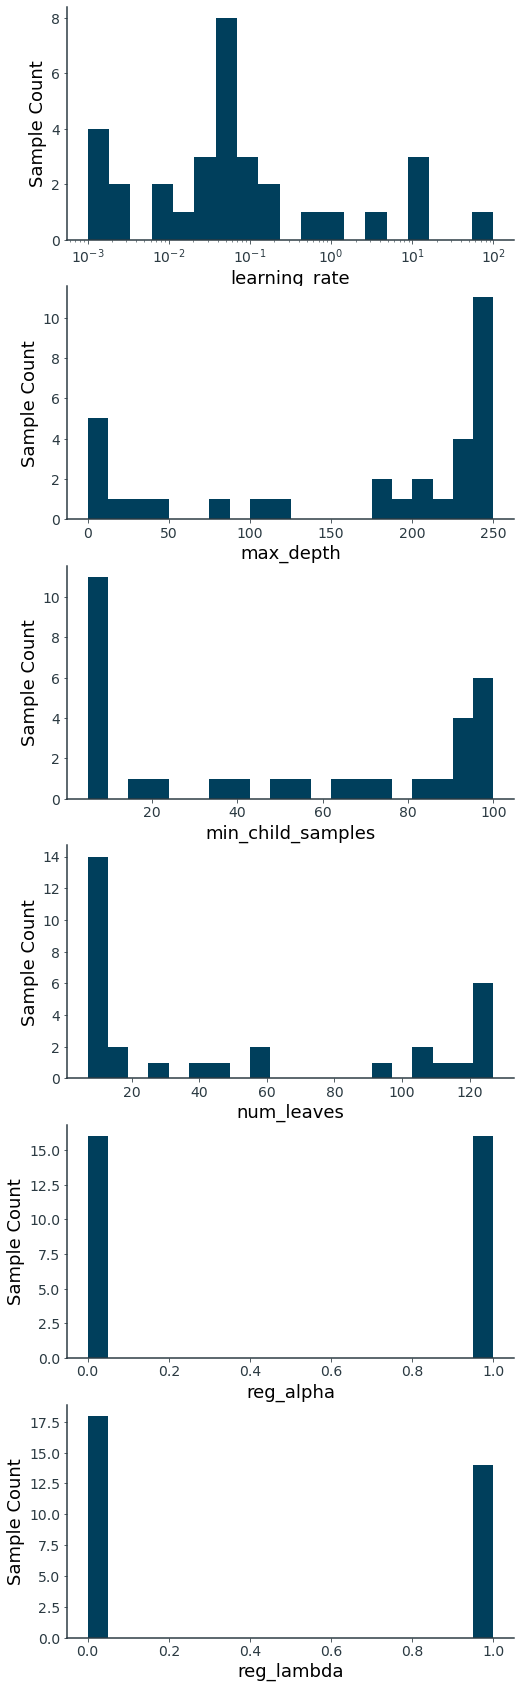

In [7]:
fig, ax = plt.subplots(len(lgb_params), 1, figsize=(8, 5*len(lgb_params)))
for i in range(len(lgb_params)):
    plot_histogram(opt.optimizer_results_[0], i, ax=ax[i])

## RandomizedSearchCV

In [8]:
lgb_params_rcv = {
    "num_leaves": randint(7, 127),
    "max_depth": list(range(10, 250))
    + [0 for _ in range(35)],  # "If a list is given, it is sampled uniformly."
    "learning_rate": loguniform(1e-3, 1e+2),
    "min_child_samples": (5, 100),
    "reg_alpha": uniform(0, 1),
    "reg_lambda": uniform(0, 1),
}

In [9]:
start = time()

opt_rcv = RandomizedSearchCV(
    model,
    lgb_params_rcv,
    n_iter=172,
    cv=cv,
    n_jobs=1,
    random_state=42,
    scoring="roc_auc"
)
opt_rcv.fit(X_train, y_train)
end = time()
print(f"\nRun time     : {(end - start) / 60:.1f} minutes")
print(f"Best score     : {opt_rcv.best_score_:.4f}")
print(f"Test score     : {opt_rcv.score(X_test, y_test):.4f}")
print("Best parameters:")
for item in opt_rcv.best_params_.items():
    print(f"\t{item}")


Run time     : 1.9 minutes
Best score     : 0.7989
Test score     : 0.7929
Best parameters:
	('learning_rate', 0.08215507070842176)
	('max_depth', 140)
	('min_child_samples', 5)
	('num_leaves', 11)
	('reg_alpha', 0.5612771975694962)
	('reg_lambda', 0.770967179954561)


## GridSearchCV

In [10]:
lgb_params_gcv = {
    "num_leaves": [7, 31],
    "max_depth": [-1, 100],
    "learning_rate": [0.01, 0.1, 1],
    "min_child_samples": [5, 25],
    "reg_alpha": [0, 0.1, 1],
    "reg_lambda": [0, 0.1, 1],
}

In [11]:
start = time()

opt_gcv = GridSearchCV(
    model,
    lgb_params_gcv,
    cv=cv,
    n_jobs=1,
    scoring="roc_auc"
)
opt_gcv.fit(X_train, y_train)
end = time()
print(f"\nRun time     : {(end - start) / 60:.1f} minutes")
print(f"Best score     : {opt_gcv.best_score_:.4f}")
print(f"Test score     : {opt_gcv.score(X_test, y_test):.4f}")
print("Best parameters:")
for item in opt_gcv.best_params_.items():
    print(f"\t{item}")

[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max

[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max

[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max

[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max